# Tanzania Water Well Classification

Analysis and model by Matt Carr, Dann Morr, and Amanda Potter

## Introduction
Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many waterpoints already established in the country, but some are in need of repair while others have failed altogether.  Understanding which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

## Goal
This project seeks to develop a model to classify the functional status of water wells in Tanzania, using data from Taarifa and the Tanzanian Ministry of Water.  This analysis is being prepared for the Tanzanian Ministry of Water to aid in improving maintenance operations by lessening the number of fully functional waterpoints that are to be inspected for repairs and limiting those inspections to the waterpoints that have a high liklihood of being in need of repair or having failed altogether. 

## Data Set
This project uses the data from the Pump it Up: Data Mining the Water Table originally compiled by Taarifa and the Tanzanian Ministry of Water.

A cleaned copy of the data is saved in this repo as `data/geodata_clean.csv`.

## Definitions
### Water well status
Functional - supplies adequate water to the population

Functional needs repair - has less than 3 months of interruption in service.

Nonfunctional  - has more than 3 months of interruption

### Water Quality definitions
Milky — Indication of turbidity as measured in NTU, water will appear milky white at 4 NTU. For household use, turbidity should ideally be kept below 5 NTU. Milky-white can also be caused by supersaturated air being released. This could have been introduced during pipe repair, or following changes in water pressure.
https://www.who.int/water_sanitation_health/publications/turbidity-information-200217.pdf

Soft — Indication of the level of calcium carbonate present in water. Below 60 mg/L is considered soft water.
https://www.usgs.gov/special-topic/water-science-school/science/hardness-water?qt-science_center_objects=0#qt-science_center_objects

Salty — measure of salinity. Fresh water contains less than 1000 ppm of dissolved salts. For our purposed assume salty is slightly or moderately saline — between 1000 and 10000 ppm dissolved salts. Ocean water is roughly 35000 ppm dissolved salts
https://www.usgs.gov/special-topic/water-science-school/science/saline-water-and-salinity?qt-science_center_objects=0#qt-science_center_objects

Fluoride — water from rivers, lakes, springs with fluoride concentration exceeding 1.5mg/L. https://www.hindawi.com/journals/jchem/2018/7140902/

Colored — indication of dissolved, suspended materials. A brown shade is generally an indication of rusted pipes. For our purposes we will assume that the water is generally safe and is an indication of rust.
https://www.usgs.gov/special-topic/water-science-school/science/water-color?qt-science_center_objects=0#qt-science_center_objects

## Table of contents:
- Imports
- EDA
 - Inspecting the Data
 - Data Anaylsis using Pandas-Profiling
 - Target variable - Status Group
 - Dropping Features
 - Train test split
 - One Hot Encoding
- Visualizations
 - Maps
 - Graphs
- Dummy Model
- First Simple Model
- Model Iterations 
- Final Model Interpretation
- Conclusion
- Further exploration 

# Imports

In [17]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#EDA
from pandas_profiling import ProfileReport

#Visualizations
import geopandas as gpd
from shapely.geometry import Point, Polygon
import plotly
import seaborn as sns


# Model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import recall_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.tree import export_graphviz
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from sklearn.tree import plot_tree

# Ensemble/XGBoost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#.py file
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.mc_functions as mcf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploratory Data Analysis 
    Please note: this is a streamlined version of the EDA. Each member of the team explored the data separately, then compared results in order to select features for our models. See the folder `notebooks/exploratory` to review each team member's individual exploration.

### Inspecting the data
    The data was downloaded from DrivenData.Org as two csv files:
    "training_set_values" and "training_set_labels"

In [5]:
vals = pd.read_csv('https://s3.amazonaws.com/drivendata-prod/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
vals.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [6]:
labels = pd.read_csv('https://s3.amazonaws.com/drivendata-prod/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


These two data sets were merged on the column "id" - which is the unique identifier for each of the water wells in this data set - and saved as a new csv that named `geodata_clean.csv`. We will use that for the rest of the work in this notebook.

In [11]:
df = pd.read_csv("../../data/geodata_clean.csv")
df.head()

,Unnamed: 0,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,geometry,x,y
0,0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,POINT (34.93809275 -9.856321769999999),34.938093,-9.856322
1,1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,POINT (34.6987661 -2.14746569),34.698766,-2.147466
2,2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,POINT (37.46066446 -3.82132853),37.460664,-3.821329
3,3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,POINT (38.48616088 -11.15529772),38.486161,-11.155298
4,4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,POINT (31.13084671 -1.82535885),31.130847,-1.825359


#### Data Anaylsis using Pandas-Profiling
    This package produces an overview of all the data, which proved very useful in expediting the process to gather informatino on the target variable (status group) identify rows and columns with duplicate information, missing values, and "zero" values.

In [13]:
profile = ProfileReport(df, title='Waterpoint Profiling Report', explorative=True)
profile.to_notebook_iframe()

TypeError: _plot_histogram() got an unexpected keyword argument 'title'

####  Information on target variable - Status Group

From our EDA we learned that values and counts for our Status Group are as follows:

- functional: 31389 
- non functional: 22268 
- functional needs repair: 3931

A topic that we discussed was how do handle the imbalance in the classes. 
Would it be an issue for a ternary classification? 
Should we try to balance the values? combine them into two categories? Over- or under-sample?

We decided to perform some further analysis before making a decision.

####  Dropping features

Our anaylsis did show that several columns  could be ignored or dropped as they contained duplicate information.
For example, there are columns for 'extraction_type' (18 categories), 'extraction_type_group' (13 categories), and 'extraction_type_class' (7 categories). All contain the same number of values, just categorized in slightly different ways. We did try several combinations of features in our models to test the different features before deciding on our final model.

#### Train test split

Regardless of the feature selection, our exploration and modeling would be carried out after performing a train test split on the data.
following this format for any given DataFrame:
```
# target variable
y = df['status_group']
# features
X = df.drop('status_group', axis=1)
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)
```
**Random State of 42 is used for all modelling** in order assure the tests could be replicated.

#### OneHotEncoding

The data set is predominantly categorical values, so we decided we would also need to implement encoding to convert the values from objects to numbers in order to perform any mode

## Visualizations using GeoPandas

A number of visualizations were created using GeoPandas to help us understand how the different values were distributed geographically, the more important visuzlizations are below, more information can be seen in the asp_explore notebooks folder.  

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
TZ.plot(ax=ax,alpha=.5,color='white',linewidth=2,edgecolor='grey')

bok_df[bok_df['status_group']== 'functional'].plot(ax = ax, markersize = 3,
                                                  color='#0081A7', marker = 'o',label = 'Functional');
bok_df[bok_df['status_group']== 'functional needs repair'].plot(ax=ax,markersize=3,
                                                                color='#FB8B24', marker = 'o',label = 'Repair Needed')
bok_df[bok_df['status_group']== 'non functional'].plot(ax=ax,markersize=3,alpha = .25,
                                                     color='#E71D36',marker='o',label = 'Non Functional')
ax.axis('off')
plt.legend(loc='upper right', fontsize='12',markerscale=8);
plt.title('Waterpoint Functional Status', loc='left', fontsize = '20');
#plt.savefig('../reports/figures/waterpoints_by_function_map', bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
TZ.plot(ax=ax,alpha=.5,color='white',linewidth=2,edgecolor='grey')
bok_df[bok_df['quantity_group']== 'enough'].plot(ax = ax, markersize = 3, alpha=.5,
                                                  color='blue', marker = 'o',label = 'Enough');
bok_df[bok_df['quantity_group']== 'insufficient'].plot(ax=ax,markersize=3,alpha=.5,
                                                                color='orange', marker = 'o',label = 'Insufficient')
bok_df[bok_df['quantity_group']== 'dry'].plot(ax=ax,markersize=3,alpha=.25,
                                                      color='brown',marker='o',label = 'Dry')
bok_df[bok_df['quantity_group']== 'seasonal'].plot(ax=ax,markersize=3,alpha=.5,
                                                                color='green', marker = 'o',label = 'Seasonal')
bok_df[bok_df['quantity_group']== 'unknown'].plot(ax=ax,markersize=3,alpha=.25,
                                                      color='black',marker='o',label = 'unknown')
ax.axis('off')
plt.legend(loc='upper right', fontsize='12',markerscale=8)
plt.title('Water Quantity Map', loc='left', fontsize = '20');
# #plt.savefig('../reports/figures/water_quantity_map', bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
TZ.plot(ax=ax,alpha=.5,color='white',linewidth=2,edgecolor='grey')
bok_df[bok_df['waterpoint_type_group']== 'communal standpipe'].plot(ax = ax, markersize = 3, alpha=.5,
                                                  color='red', marker = 'o',label = 'Communal Standpipe');
bok_df[bok_df['waterpoint_type_group']== 'hand pump'].plot(ax=ax,markersize=3,alpha=.5,
                                                                color='orange', marker = 'o',label = 'Hand Pump')
bok_df[bok_df['waterpoint_type_group']== 'improved spring'].plot(ax=ax,markersize=3,alpha=.5,
                                                      color='yellow',marker='o',label = 'Improved Spring')
bok_df[bok_df['waterpoint_type_group']== 'cattle trough'].plot(ax = ax, markersize = 3, alpha=.5,
                                                  color='green', marker = 'o',label = 'Cattle Trough');
bok_df[bok_df['waterpoint_type_group']== 'dam'].plot(ax=ax,markersize=3,alpha=.5,
                                                               color='blue', marker = 'o',label = 'Dam')
bok_df[bok_df['waterpoint_type_group']== 'other'].plot(ax=ax,markersize=3,alpha=.25,
                                                      color='grey',marker='o',label = 'Other')
ax.axis('off')
plt.legend(loc='upper right', fontsize='10',markerscale=8);
plt.title('Waterpoint Type Map', loc='left', fontsize = '20');
#plt.savefig('../reports/figures/waterpoints_by_type_map', bbox_inches='tight')

## Visualizations using Matplotlib and Seaborn

Create dictionaries to plot the different proportions of waterwell status in varying waterpoint types.

In [14]:
wq_types = df['quantity_group'].unique()
wq_b_bar = {}
wq_m_bar = {}
wq_t_bar = {}

for wq in wq_types:
    tot_observs = len(df[df['quantity_group'] == wq])
    func = len(df[(df['quantity_group'] == wq) & (df['status_group'] == 'functional')])
    fail = len(df[(df['quantity_group'] == wq) & (df['status_group'] == 'non functional')])
    repair = len(df[(df['quantity_group'] == wq) & (df['status_group'] == 'functional needs repair')])
    wq_b_bar[wq] = 100
    wq_m_bar[wq] = round(((fail+func)/tot_observs)*100, 0)
    wq_t_bar[wq] = round((func/tot_observs)*100, 0)

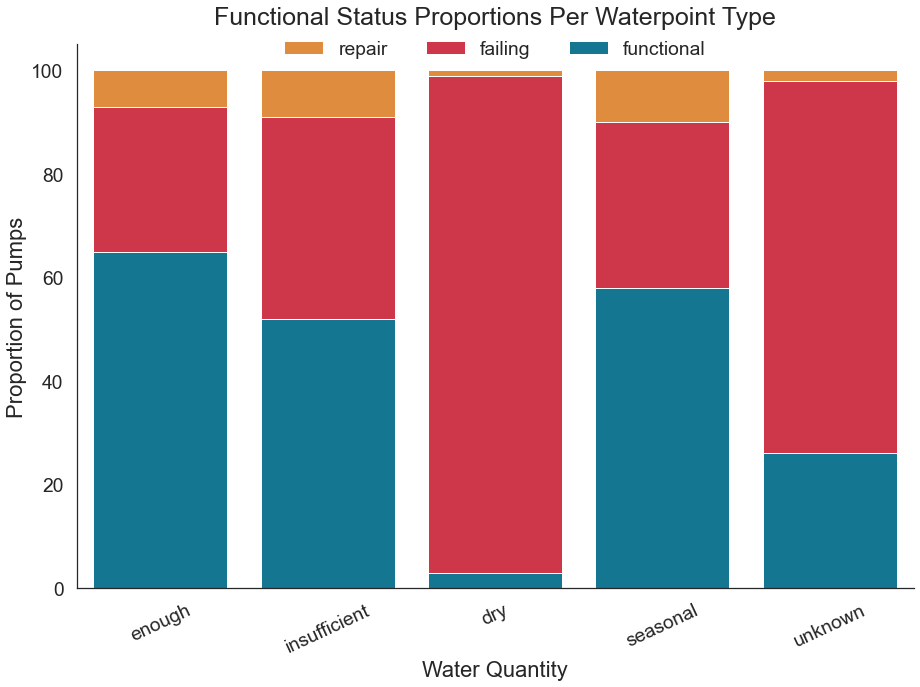

In [35]:
sns.set_context({"figure.figsize": (15, 10)})
sns.set(font_scale=1.75)
sns.set_style("white")

x = list(wq_b_bar.keys())
y1 = list(wq_b_bar.values())
y2 = list(wq_m_bar.values())
y3 = list(wq_t_bar.values())

bottom_bar = sns.barplot(x=x, y=y1, color='#fb8b24', label='repair')
middle_bar = sns.barplot(x=x, y=y2, color='#e71d36', label='failing')
top_bar = sns.barplot(x=x, y=y3, color='#0081a7', label='functional')

bottom_bar.set_xlabel('Water Quantity', fontsize=22)
bottom_bar.set_ylabel('Proportion of Pumps', fontsize=22)
bottom_bar.set_xticklabels(x, rotation=25)
bottom_bar.set_title('Functional Status Proportions Per Waterpoint Type', fontsize=25, pad=20)

sns.despine(top=True, right=True)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.04), ncol=3);

## Dummy and First Simple Models

To set a base line, a dummy model was created using a Dummy Classifier model.
Random state of 42 was assigned, first value in each columns was dropped, but all other settings are default.

In [ ]:
#Instantiate OneHotEncoder.

ohe = OneHotEncoder(drop='first')

# Fit and transform a seleceted feature group.

dummies = ohe.fit_transform(df[['extraction_type_class', 'quality_group', 
                                'quantity_group','source_class', 'basin', 
                                'management_group', 'payment', 'region']])

# Create a dataframe of dummy values.

dummies_df = pd.DataFrame(dummies.todense(), columns=ohe.get_feature_names(),
                         index=df.index)

# Check results of encoding - not necessary but I'm cautious.

dummies_df.head()

    Train test split

In [ ]:
# Identify target variable

y = df['status_group']

# Identify features

X = dummies_df

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

### Dummy Model

    Instantiate Dummy classifier, fit data, and predict.

In [ ]:
#Instantiate.

dummy_model = DummyClassifier(random_state=42)

#Fit.

dummy_model.fit(X_train, y_train)

#Predict.

dummy_preds=dummy_model.predict(X_train)

This function returns the Recall Score, Classification Report, and Confusion Matrix for a model.

In [ ]:
# Display scores.

mcf.display_scores(y_train, dummy_preds, model_name = "Dummy Model");

    Plotting the Confusion Matrix - redundant, but I like a visualization too

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("Confusion Matrix - Dummy Model")
plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, cmap="Blues");

#### Now we have a base line to improve upon.
- Overall recall score 0.45
 - functional 0.55
 - functional needs repair 0.06
 - nonfunctional 0.39

### First Simple Model
    Note: As with the EDA, this is a streamlined version of the modelling process. Each member of the team ran separate models. We would then compare results and make adjustments to further iterations.
    See the folder `notebooks/exploratory` to review each team member's individual exploration.

### This first simple model is a Decision Tree Classifier
using the same X and y as for the Dummy Model

In [ ]:
# Instantiate.

clf = DecisionTreeClassifier(max_depth=3,random_state=42)

# Fit.

clf.fit(X_train, y_train)

# Predict.

y_pred = (clf.predict(X_train))

# Display scores.
mcf.display_scores(y_train, y_pred, model_name = "FSM");

#### This shows some improvement over the Dummy - which is definitely good.
- Overall recall score 0.45 -> 0.67
 - functional 0.55 -> 0.89
 - functional needs repair 0.06 -> 0.00 (?)
 - nonfunctional 0.39 -> 0.48
 
These scores could probably be improved with a "deeper" model. This tree had a max depth of 3.

I'm going to plot a graph to see how the tree splits...

In [ ]:
# Create DOT data

dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=X_train.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph

graph = graph_from_dot_data(dot_data)  

# Show graph

Image(graph.create_png())

... and review the Feature Importances

In [ ]:
for col, feature in zip(X_train.columns, clf.feature_importances_):
    print(col, feature)

#### The features of highest importance on this model are: 
- Extraction Type other 0.44(!) <- wow, that's high
- Water Quantity enough 0.28
- Water Quantity insufficient 0.18

## Model interations

After comparing results of individual FSMs, we argeed that we should move forward with a Random Forest Classifier and the features should include one feature from each group of categories

- Geographic Location
- Quantity of Water
- Quality of Water
- How the waterpoint is managed
- Extraction type the waterpoint uses
- Water Source

Changes to iterations included selection of features, hyperparameter tuning, and boosting methods.

## Final model

### The final model is a Random Forest Classifier, using 500 estimators and the following feature set:
- lga (Geographic Location)
- quantity_group (Quantity of Water)
- quality_group (Quality of Water)
- management_group (How the waterpoint is managed)
- extraction_type (Extraction type the waterpoint uses)
- source_type (Water Source)

Created a smaller dataframe of the feature set.

In [ ]:
st_df = df[['status_group','lga','quantity_group','quality_group','management_group',
            'extraction_type','source_type','waterpoint_type']]
st_df.head()

Identify target and features.

In [ ]:
# Identify target variable.
y = st_df['status_group']

# Identify features.

X = st_df.drop('status_group', axis=1)

In [ ]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

OneHotEncode the training set

In [ ]:
# Fit.

ohe.fit(X_train)

# Transform.

X_train_ohe = ohe.transform(X_train).toarray()

Instantiate Random Forest Classifier.

Fit.

Predict.

Display Scores.

In [ ]:
# Instantiate a RandomForestClassifier.

rfc = RandomForestClassifier(n_estimators=500, random_state=42)

# Fit.

rfc.fit(X_train_ohe, y_train)

# Predict.

rfc_preds = rfc.predict(X_train_ohe)

# Display scores.

mcf.display_scores(y_train, rfc_preds , model_name='Random Forest Final Training');

### Run the test set

Encode the test set.

In [ ]:
X_test_ohe = ohe.transform(X_test)

Fit.

Predict.

Display Scores.

In [ ]:
# Fit.

rfc.fit(X_test_ohe, y_test)

# Predict.

y_preds = rfc.predict(X_test_ohe)

# Display scores.

mcf.display_scores(y_test, y_preds , model_name='Random Forest Test Data');

#### Plot the final confusion matrix

In [ ]:
fig, ax = plt.subplots()
figsize=(20,20)
fig.suptitle("Final Model Confusion Matrix")
plot_confusion_matrix(rfc, X_test_ohe, y_test, ax=ax, cmap="Blues");

#### Comparison of our scores, Dummy to FSM to Final Model test 
- **Overall recall score** 0.45 -> 0.67 -> **0.83**
 - **functional** 0.55 -> 0.89 -> **0.93**
 - **functional needs repair** 0.06 -> 0.00 -> **0.36**
 - **nonfunctional** 0.39 -> 0.48 -> **0.77**

## Conclusions and Recommendations

The final model was a Random Forest Classifier that achieved an overall Recall Score of  0.83.


### The recall scores for each catergory are as follows:
- Functional  0.93
- Nonfunctional 0.77
- Functional needs repair 0.36

The model performed best at the Functional wells, adequately on Nonfunctional wells, and had the most trouble correctly predicting the Functional needs repair.

We found that overall the data was not reliably gathered, so the results were not expected to be particularly accurate.

### Recommendations are:

- Focus resources on pumps that are failing or in need of repairs.

- Implement pumps types in the future that are least likely to fail.

- Work with local governments to ensure accurate gathering of further data.

- Create standard definition for governments to follow when classifying functional status of water pumps.

## Further exploration 
- Are there areas/regions that have more failing wells?
- Does water quality appear to contribute to the likelihood of a well failing/needing repair?
- How is the status of a well associated with the population using the well, if at all?
- Is there a difference in rates of failure/repair between groundwater and surface water wells?
- is there a difference in failure/repair with the type of pump?
- Does the age of the well indicate liklihood of needed repair or failure?